In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt

# 1. get mnist from tensorflow_datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:

# function to generate noise
# according to image shape and noise rate
def noise_function(noise_rate, shape):

  # create noise tensor with the same shape as images
  random_noise = list()
  len = 1
  # calculate how long the list should be so that it fits to shape (28, 28, 1)
  for elem in shape:
    len = len * elem
  
  # make sure that there is only as much noise as noise_rate defines
  for index in range(len):
    # if noise_rate = 0.05 prob_var = 20 and we can calculate every 20th element randomly is kept, the others are zero
    prob_var = 100 / (noise_rate * 100)
    var = random.randint(1, prob_var)
    
    # random int var matches prob_var -> add no noise
    if var != prob_var:
      random_noise.append(0)
    # else generate random number from nroaml distribution and add to list
    else:
      random_noise.append(float(np.random.normal(size=1)))

  # return list containing seperat noise factor (or 0) for each pixel
  return random_noise


In [ ]:

# 2.1 Prepare dataset
def preprocess_data(mnist, batch_size, noise_rate):

  # Step 2) normalize image and have sensible dimension
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  mnist = mnist.map(lambda img, target: (tf.expand_dims(img, axis=-1), target))
  # target should be original image
  mnist = mnist.map(lambda img, target: (img, img))

  # Step 3) create and add noise to images

  # tf.convert_to_tensor: call noise_function and convert the output list into tensor
  # tf.reshape: then reshape it to "shape"
  # tf.math.add: add noise to every image using 
  mnist = mnist.map(lambda img, target: (tf.math.add(img, tf.reshape((tf.convert_to_tensor(noise_function(noise_rate, img.shape), dtype=tf.float32)), img.shape)), target))
  # clip tensors (make sure that with added noise the pixel values are still between 0 and 1
  mnist = mnist.map(lambda img, target: (tf.clip_by_value(img, clip_value_min=0, clip_value_max=1), target))

  #mnist_train =  mnist.take(10)

  # Loop through the first 10 images and plot them
  for i, (image, image_2) in enumerate(mnist.take(5)):
    image = tf.squeeze(image)  # Remove the singleton dimensions
    plt.subplot(5, 2, min(i * 2 + 1, 10))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title("Noisy Image as Input")
    plt.axis("off")

    # Plot the second image in the second subplot
    image_2 = tf.squeeze(image_2)
    plt.subplot(5, 2, min(i * 2 + 2, 10))
    plt.imshow(image_2, cmap=plt.cm.binary)
    plt.title("Original as Target")
    plt.axis("off")

  plt.tight_layout()
  plt.show()
  
  # Step 4) other preprocessing steps
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(batch_size)
  mnist = mnist.prefetch(20)
  
  return mnist



In [ ]:
# visualize noisy images from test and train data as well as targets 
def visualize(data, num):

  data_train =  data.take(num)

  # Loop through the first 10 images and plot them
  # num/2 test and num/2 train images
  for i, (image, image_2) in enumerate(data_train.take(num / 2)):
    image = tf.squeeze(image)  # Remove the singleton dimensions
    plt.subplot(5, 2, min(i * 2 + 1, num))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title("Noisy Image as Input")
    plt.axis("off")

    # Plot the second image in the second subplot
    image_2 = tf.squeeze(image_2)
    plt.subplot(5, 2, min(i * 2 + 2, num))
    plt.imshow(image_2, cmap=plt.cm.binary)
    plt.title("Original as Target")
    plt.axis("off")


  plt.tight_layout()
  plt.show()

In [ ]:
#Autoencoder class
class Autoencoder(tf.keras.Model):
    def __init__(self):
      super().__init__()

      # initialization of encoder and decoder in autoencoder constructor
      self.encoder = Encoder(embedding_size=28, dtype=tf.float32)
      self.decoder = Decoder(embedding_size=28)

      # optimizer, loss function and metrics
      self.metrics_list = [tf.keras.metrics.Mean(name="loss")] 
        
      self.loss_function = tf.keras.losses.MeanSquaredError()
      self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # call function, seperately calling them
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    # metrics property
    @property
    def metrics(self):
        return self.metrics_list

    # reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics_list:
            metric.reset_states()


    # 5. train step method
    def train_step(self, data):
        img, label = data
        
        with tf.GradientTape() as tape:
            output = self(img, training=True)
            label = tf.reshape(label, output.shape)
            loss = self.loss_function(label, output) + tf.reduce_sum(self.losses)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update the state of the metrics according to loss and accuracy
        self.metrics[0].update_state(loss)

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}


    # 6. test_step method
    def test_step(self, data):

        img, label = data
        output = self(img, training=False)
        label = tf.reshape(label, output.shape)
        loss = self.loss_function(label, output) + tf.reduce_sum(self.losses)

        # update the state of the metrics according to loss and accuracy
        self.metrics[0].update_state(loss)
        #print({m.name: m.result() for m in self.metrics})

        # return a dictionary with metric names as keys and metric results as values
        return {m.name: m.result() for m in self.metrics}

In [ ]:
# separate model for the encoder
class Encoder(tf.keras.Model):
    def __init__(self, embedding_size, **kwargs):
        super().__init__(**kwargs)
        
        self.embedding_size = embedding_size

        # encoder layers
        self.E_Input = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))
        # reduce the size of feature maps like a CNN
        self.E_Conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')
        self.E_Conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')
        #  flatten the feature maps
        self.E_Flatten = tf.keras.layers.Flatten()
        # No activation, dense layer to produce an embedding of the embedding_size
        self.E_Dense = tf.keras.layers.Dense(2*embedding_size)

    def call(self, inputs, training=False):
      x = self.E_Input(inputs)
      x = self.E_Conv_1(x)
      x = self.E_Conv_2(x)
      x = self.E_Flatten(x)
      x = self.E_Dense(x)

      return x # return embedding


In [ ]:
# separate model for the encoder
class Decoder(tf.keras.Model):
    def __init__(self, embedding_size):
        super().__init__()

        self.embedding_size = embedding_size

        # decoder layers
        self.D_Input = tf.keras.layers.InputLayer(input_shape=(embedding_size,))
        # dense layer to restore the dimensionality of the flattened feature maps from the encoder 
        self.D_Dense = tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu)
        # reshape the resulting vector into feature maps again
        self.D_Reshape = tf.keras.layers.Reshape(target_shape=(7, 7, 32))
        # (upsampling or) transposed convolutions to mirror the encoder
        self.D_ConvT_1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.D_ConvT_2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')
        # No activation, a convolutional layer with one filter and sigmoid activation to produce an output image
        self.D_ConvT_3 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')


    def call(self, inputs, training=False):
      x = self.D_Input(inputs) # takes the embedding of the encoder as input
      x = self.D_Dense(x)
      x = self.D_Reshape(x)
      x = self.D_ConvT_1(x)
      x = self.D_ConvT_2(x)
      x = self.D_ConvT_3(x)

      return x # return output


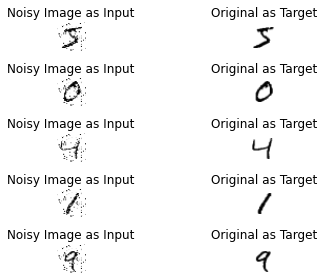

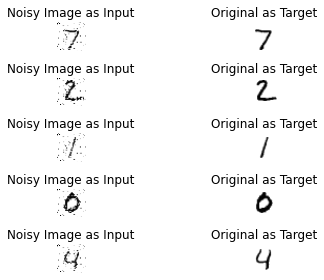

In [ ]:
# create datasets
train_ds = preprocess_data(train_data, batch_size=32, noise_rate=0.5) #train_ds.apply(preprocess)
test_ds = preprocess_data(test_data, batch_size=32, noise_rate=0.5) #val_ds.apply(preprocess)


In [ ]:

# TASK 4 - Training the networks
def training():
  
  # instantiate the model
  autoencoder = Autoencoder()

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  loss = tf.keras.losses.MeanSquaredError()

  # compile the model (here, adding a loss function and an optimizer)
  autoencoder.compile(optimizer = optimizer, loss=loss)

  # internal training loop function
  def training_loop(model, train_ds, test_ds, epochs, save_path=False): 

    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        # Validation:
        # (we do the validation first so that we get the loss before training the network)
        for data in test_ds:
           metrics = model.test_step(data)
        
        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()    
        
        # Training:
        for data in train_ds:
           #print('Loop 1')
           metrics = model.train_step(data)

        # print the metrics
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
        print("\n")
  
  training_loop(autoencoder, train_ds, test_ds, 10)
  return

training()


Epoch 0:
['test_loss: 0.9243607521057129']
['train_loss: 0.06756433844566345']


Epoch 1:
['test_loss: 0.0960836187005043']
['train_loss: 0.020640261471271515']


Epoch 2:
['test_loss: 0.07797645777463913']
['train_loss: 0.017133666202425957']


Epoch 3:
['test_loss: 0.08058097213506699']
['train_loss: 0.015554020181298256']


Epoch 4:
['test_loss: 0.08064813911914825']
['train_loss: 0.014596187509596348']


Epoch 5:
['test_loss: 0.07731997966766357']
['train_loss: 0.013916383497416973']


Epoch 6:
['test_loss: 0.0797390341758728']
['train_loss: 0.013399473391473293']


Epoch 7:
['test_loss: 0.08625635504722595']
['train_loss: 0.01300850510597229']


Epoch 8:
['test_loss: 0.08192021399736404']
['train_loss: 0.012690896168351173']


Epoch 9:
['test_loss: 0.08231871575117111']
['train_loss: 0.012422102503478527']




/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


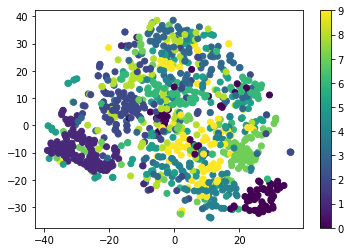

In [ ]:
# ja ...
from sklearn.manifold import TSNE

# Create the encoder model
encoder = Encoder(embedding_size=10)

# take first 1000 elems from data
embeddings = []
labelzzz = []

test_data = test_data.map(lambda img, target: (tf.cast(img, tf.float32), target))
test_data = test_data.map(lambda img, target: (tf.expand_dims(img, axis=-1), target))
test_data = test_data.batch(1)



# Embed the first 1000 images of the test set
for i, (x, y) in enumerate(test_data): 
  if i == 1000:
    break
  embeddings.append(encoder(x))
  labelzzz.append(y)  

# Use t-SNE to reduce the dimensionality of the embeddings to 2
tsne = TSNE(n_components=2)
# Concatenate the embeddings into a single tensor
embeddings = tf.concat(embeddings, axis=0)

embeddings_2d = tsne.fit_transform(embeddings)
 
# Plot the data points, coloring them according to their class
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labelzzz)
plt.colorbar()
plt.show()

In [11]:
img_list = []

for i, (img, target) in enumerate(test_data.batch(2)):
    if i > 1:
        break
    img_list.append(img)
    
img_1 = img_list[0]
img_2 = img_list[1]

# Embed the images using the encoder
decoder = Decoder(embedding_size=10)

embedding1 = encoder(img_1)
embedding2 = encoder(img_2)

# Interpolate linearly between the two embeddings
num_interpolations = 10
interpolated_embeddings = []

for i in range(num_interpolations):
    alpha = i / (num_interpolations - 1)
    interpolated_embedding = (1 - alpha) * embedding1 + alpha * embedding2
    interpolated_embeddings.append(interpolated_embedding)
    
#print("HEELLOOO",interpolated_embeddings)

# Use the decoder to reconstruct the images from the interpolated embed
interpolated_image = decoder(interpolated_embeddings[0])


# Plot the interpolated images
for i, image in enumerate(interpolated_images):
    plt.subplot(1, num_interpolations, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

NameError: ignored